In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.experimental import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu
from jax.config import config
from jax import lax
from jax.flatten_util import ravel_pytree
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors as colors
from scipy.interpolate import interp2d
%matplotlib inline

/scratch/sifanw/anaconda3/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


# Architectures 

In [2]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply


# Define the neural net
def modified_MLP(layers, activation=relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b

  def init(rng_key):
      U1, b1 =  xavier_init(random.PRNGKey(12345), layers[0], layers[1])
      U2, b2 =  xavier_init(random.PRNGKey(54321), layers[0], layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2) 

  def apply(params, inputs):
      params, U1, b1, U2, b2 = params
      U = activation(np.dot(inputs, U1) + b1)
      V = activation(np.dot(inputs, U2) + b2)
      for W, b in params[:-1]:
          outputs = activation(np.dot(inputs, W))
          inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V) 
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

def modified_deeponet(branch_layers, trunk_layers, activation=relu):

  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b
  
  def init(rng_key1, rng_key2):
      U1, b1 =  xavier_init(random.PRNGKey(12345), branch_layers[0], branch_layers[1])
      U2, b2 =  xavier_init(random.PRNGKey(54321), trunk_layers[0], trunk_layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key1, *keys1 = random.split(rng_key1, len(branch_layers))
      key2, *keys2 = random.split(rng_key2, len(trunk_layers))
      branch_params = list(map(init_layer, keys1, branch_layers[:-1], branch_layers[1:]))
      trunk_params = list(map(init_layer, keys2, trunk_layers[:-1], trunk_layers[1:]))
      return (branch_params, trunk_params, U1, b1, U2, b2)

  def apply(params, u, y):
      branch_params, trunk_params, U1, b1, U2, b2 = params
      U = activation(np.dot(u, U1) + b1)
      V = activation(np.dot(y, U2) + b2)
      for k in range(len(branch_layers)-2):
          W_b, b_b =  branch_params[k]
          W_t, b_t =  trunk_params[k]

          B = activation(np.dot(u, W_b) + b_b)
          T = activation(np.dot(y, W_t) + b_t)

          u = np.multiply(B, U) + np.multiply(1 - B, V) 
          y = np.multiply(T, U) + np.multiply(1 - T, V) 

      W_b, b_b =  branch_params[-1]
      W_t, b_t =  trunk_params[-1]
      B = np.dot(u, W_b) + b_b
      T = np.dot(y, W_t) + b_t

      B1 = B[:100]
      B2 = B[100:200]
      B3 = B[200:]

      T1 = T[:100]
      T2 = T[100:200]
      T3 = T[200:]

      # returns
      u = np.sum(B1 * T1)   
      v = np.sum(B2 * T2) 
      p = np.sum(B3 * T3) 
      return u, v, p

  return init, apply


# Data Sampler

In [3]:
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u
        self.y = y
        self.s = s
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs


# Physics-informed DeepONet

In [5]:
# Define the model
class PI_DeepONet:
    def __init__(self, arch, weights, branch_layers, trunk_layers):  
        self.arch = arch
        self.weights = weights  

        # Network initialization and evaluation functions
        if self.arch =='MLP':
            self.branch_init, self.branch_apply = MLP(branch_layers, activation=np.tanh)
            self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=np.tanh)

            branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
            trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
            params = (branch_params, trunk_params)
        
        if self.arch =='modified_MLP':
            self.branch_init, self.branch_apply = modified_MLP(branch_layers, activation=np.tanh)
            self.trunk_init, self.trunk_apply = modified_MLP(trunk_layers, activation=np.tanh)

            branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
            trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
            params = (branch_params, trunk_params)
        
        if self.arch =='modified_deeponet':
            self.init, self.apply = modified_deeponet(branch_layers, trunk_layers, activation=np.tanh)
            params = self.init(rng_key1 = random.PRNGKey(1234), rng_key2 = random.PRNGKey(4321))

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.9)
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        _, self.unravel = ravel_pytree(params)

        self.itercount = itertools.count()
        
        # Logger
        self.loss_log = []
        self.loss_u_bc1_log = []
        self.loss_v_bc1_log = []
        self.loss_u_bc2_log = []
        self.loss_v_bc2_log = []
        self.loss_p_bc3_log = []
        self.loss_r_u_log = []
        self.loss_r_v_log = []
        self.loss_r_c_log = []
    
                                          
    def indicator(self, x, y, a, b):
        # return 1 for points outside the ellipse otherwise 0 
        cond = ((x - 0.5)**2 / a**2 +  (y - 0.5)**2 / b**2) > 1
        return 1.0 * cond

    # Define the opeartor net
    def operator_net(self, params, gamma, x, y):
        z = np.stack([x, y])
        u, v, p = self.apply(params, gamma, z)
        return u, v, p

    # Define the opeartor net
    def operator_net(self, params, gamma, x, y):
        if self.arch == 'modified_deeponet':
            z = np.stack([x, y])
            u, v, p = self.apply(params, gamma, z)
        else:
            z = np.stack([x, y])
            branch_params, trunk_params = params
            B = self.branch_apply(branch_params, gamma)
            T = self.trunk_apply(trunk_params, z)
            B1 = B[:100]
            B2 = B[100:200]
            B3 = B[200:]

            T1 = T[:100]
            T2 = T[100:200]
            T3 = T[200:]

            # returns
            u = np.sum(B1 * T1)   
            v = np.sum(B2 * T2) 
            p = np.sum(B3 * T3) 
        return u, v, p
 
    def u_fn(self, params, gamma, x, y):
        u, _, _ = self.operator_net(params, gamma, x, y)
        return u
        
    def v_fn(self, params, gamma, x, y):
        _, v, _ = self.operator_net(params, gamma, x, y)
        return v

    def p_fn(self, params, gamma, x, y):
        _, _, p = self.operator_net(params, gamma, x, y)
        return p
    
    def u_x_fn(self, params, gamma, x, y):
        u_x = grad(self.u_fn, argnums=2)(params, gamma, x, y)
        return u_x

    def v_x_fn(self, params, gamma, x, y):
        v_x = grad(self.v_fn, argnums=2)(params, gamma, x, y)
        return v_x
  
    def residual_net(self, params, gamma, x, y, a, b):

        u_x = grad(self.u_fn, argnums = 2)(params, gamma, x, y)
        v_x = grad(self.v_fn, argnums = 2)(params, gamma, x, y)
        p_x = grad(self.p_fn, argnums = 2)(params, gamma, x, y)

        u_y = grad(self.u_fn, argnums = 3)(params, gamma, x, y)
        v_y = grad(self.v_fn, argnums = 3)(params, gamma, x, y)
        p_y = grad(self.p_fn, argnums = 3)(params, gamma, x, y)

        u_xx = grad(grad(self.u_fn, argnums = 2), argnums=2)(params, gamma, x, y)
        v_xx = grad(grad(self.v_fn, argnums = 2), argnums=2)(params, gamma, x, y)

        u_yy = grad(grad(self.u_fn, argnums = 3), argnums=3)(params, gamma, x, y)
        v_yy = grad(grad(self.v_fn, argnums = 3), argnums=3)(params, gamma, x, y)

        indicator = self.indicator(x, y, a, b)

        # PDE residual
        res_u = - (u_xx + u_yy) + p_x 
        res_v = - (v_xx + v_yy) + p_y
        res_c = u_x + v_y

        return res_u * indicator, res_v * indicator, res_c * indicator

    def res_u_fn(self, params, gamma, x, y, a, b):
        res_u, _, _ = self.residual_net(params, gamma, x, y, a, b)
        return res_u
        
    def res_v_fn(self, params, gamma, x, y, a, b):
        _, res_v, _ = self.residual_net(params, gamma, x, y, a, b)
        return res_v

    def res_c_fn(self, params, gamma, x, y, a, b):
        _, _, res_c = self.residual_net(params, gamma, x, y, a, b)
        return res_c  
    
    def compute_K_u(self, params, gamma, x, y):
        K_u = grad(self.u_fn, argnums=0)(params, gamma, x, y)
        K_u, _ = ravel_pytree(K_u)
        K_u = np.dot(K_u, K_u)
        return K_u

    def compute_K_v(self, params, gamma, x, y):
        K_v = grad(self.v_fn, argnums=0)(params, gamma, x, y)
        K_v, _ = ravel_pytree(K_v)
        K_v = np.dot(K_v, K_v)
        return K_v
    
    def compute_K_p(self, params, gamma, x, y):
        K_p = grad(self.p_fn, argnums=0)(params, gamma, x, y)
        K_p, _ = ravel_pytree(K_p)
        K_p = np.dot(K_p, K_p)
        return K_p
    
    def compute_K_ru(self, params, gamma, x, y, a, b):
        K_ru = grad(self.res_u_fn, argnums=0)(params, gamma, x, y, a, b)
        K_ru, _ = ravel_pytree(K_ru)
        K_ru = np.dot(K_ru, K_ru)
        return K_ru

                                          
    def compute_K_rv(self, params, gamma, x, y, a, b):
        K_rv = grad(self.res_v_fn, argnums=0)(params, gamma, x, y, a, b)
        K_rv, _ = ravel_pytree(K_rv)
        K_rv = np.dot(K_rv, K_rv)
        return K_rv

                                          
    def compute_K_rc(self, params, gamma, x, y, a, b):
        K_rc = grad(self.res_c_fn, argnums=0)(params, gamma, x, y, a, b)
        K_rc, _ = ravel_pytree(K_rc)
        K_rc = np.dot(K_rc, K_rc)
        return K_rc

    @partial(jit, static_argnums=(0,))                                        
    def loss_bc1(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        gamma, y = inputs
        # Compute forward pass
        u_pred, v_pred, p_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, gamma, y[:,0], y[:,1])
        # Compute loss
        loss_u =  np.mean((u_pred)**2)
        loss_v =  np.mean((v_pred)**2)
        return loss_u, loss_v

    @partial(jit, static_argnums=(0,))                                          
    def loss_bc2(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        gamma, y = inputs
        # Compute forward pass
        u_pred, v_pred, p_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, gamma, y[:,0], y[:,1])
        # Compute loss
        loss_u =  np.mean((u_pred - outputs[:,0])**2)
        loss_v =  np.mean((v_pred - outputs[:,1])**2)
        return loss_u, loss_v

    @partial(jit, static_argnums=(0,))                                        
    def loss_bc3(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        gamma, y = inputs
        # Compute forward pass
        _, _, p_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, gamma, y[:,0], y[:,1])
        # Compute loss
        loss_p =  np.mean((p_pred)**2) 
        return loss_p
                                          
    @partial(jit, static_argnums=(0,))
    def loss_physics(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        gamma, y = inputs
        a = y[:, 2]
        b = y[:, 3]
        # Compute forward pass
        res_u_pred, res_v_pred, res_c_pred= vmap(self.residual_net, (None, 0, 0, 0, 0, 0))(params, gamma, y[:,0], y[:, 1], y[:,2], y[:, 3])
 
        # Compute loss
        loss_res_u = np.mean((res_u_pred)**2)
        loss_res_v = np.mean((res_v_pred)**2)
        loss_res_c = np.mean((res_c_pred)**2)
        return loss_res_u, loss_res_v, loss_res_c    
    
    @partial(jit, static_argnums=(0,))
    def loss(self, params, bc1_batch, bc2_batch, bc3_batch, physics_batch):
        # Fetch data
        bc1_inputs, bc1_outputs = bc1_batch
        bc2_inputs, bc2_outputs = bc2_batch
        bc3_inputs, bc3_outputs = bc3_batch
        res_inputs, res_outputs = physics_batch

        gamma_bc1, y_bc1 = bc1_inputs
        gamma_bc2, y_bc2 = bc2_inputs
        gamma_bc3, y_bc3 = bc3_inputs   
        gamma_res, y_res = res_inputs

        # Compute forward pass
        u_bc1_pred, v_bc1_pred, _ = vmap(self.operator_net, (None, 0, 0, 0))(params, gamma_bc1, y_bc1[:,0], y_bc1[:,1])
        u_bc2_pred, v_bc2_pred, _ = vmap(self.operator_net, (None, 0, 0, 0))(params, gamma_bc2, y_bc2[:,0], y_bc2[:,1])
        _, _, p_bc3_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, gamma_bc3, y_bc3[:,0], y_bc3[:,1])
        res_u_pred, res_v_pred, res_c_pred= vmap(self.residual_net, (None, 0, 0, 0, 0, 0))(params, gamma_res, y_res[:,0], y_res[:, 1], y_res[:,2], y_res[:,3])

        # Compute weights
        if self.weights=='no_weights':
            lam_u_bc1 = 1
            lam_v_bc1 = 1
            lam_u_bc2 = 1
            lam_v_bc2 = 1
            lam_p_bc3 = 1

            lam_r_u = 1
            lam_r_v = 1
            lam_r_c = 1
      
        else:
            K_u_bc1 = vmap(self.compute_K_u, (None, 0, 0, 0))(params, gamma_bc1, y_bc1[:,0], y_bc1[:,1])
            K_v_bc1 = vmap(self.compute_K_v, (None, 0, 0, 0))(params, gamma_bc1, y_bc1[:,0], y_bc1[:,1])
            K_u_bc2 = vmap(self.compute_K_u, (None, 0, 0, 0))(params, gamma_bc2, y_bc2[:,0], y_bc2[:,1])
            K_v_bc2 = vmap(self.compute_K_v, (None, 0, 0, 0))(params, gamma_bc2, y_bc2[:,0], y_bc2[:,1])
            K_p_bc3 = vmap(self.compute_K_p, (None, 0, 0, 0))(params, gamma_bc3, y_bc3[:,0], y_bc3[:,1])

            K_ru = vmap(self.compute_K_ru, (None, 0, 0, 0, 0, 0))(params, gamma_res, y_res[:,0], y_res[:,1], y_res[:,2], y_res[:,3])
            K_rv = vmap(self.compute_K_rv, (None, 0, 0, 0, 0, 0))(params, gamma_res, y_res[:,0], y_res[:,1], y_res[:,2], y_res[:,3])
            K_rc = vmap(self.compute_K_rc, (None, 0, 0, 0, 0, 0))(params, gamma_res, y_res[:,0], y_res[:,1], y_res[:,2], y_res[:,3])

            K = np.stack([K_u_bc1, K_v_bc1, K_u_bc2, K_v_bc2, K_p_bc3, K_ru, K_rv, K_rc])

            if self.weights == 'global_NTK_weights':
                K_sum = np.sum(K)

                lam_u_bc1 = lax.stop_gradient(K_sum / np.sum(K_u_bc1))
                lam_v_bc1 = lax.stop_gradient(K_sum / np.sum(K_v_bc1))
                lam_u_bc2 = lax.stop_gradient(K_sum / np.sum(K_u_bc2))
                lam_v_bc2 = lax.stop_gradient(K_sum / np.sum(K_v_bc2))
                lam_p_bc3 = lax.stop_gradient(K_sum / np.sum(K_p_bc3))

                lam_r_u = lax.stop_gradient(K_sum / np.sum(K_ru))
                lam_r_v = lax.stop_gradient(K_sum / np.sum(K_rv))
                lam_r_c = lax.stop_gradient(K_sum / np.sum(K_rc))

            elif self.weights == 'local_NTK_weights':
    
                K_max = K.max()
                
                lam_u_bc1 = lax.stop_gradient(K_max / K_u_bc1)
                lam_v_bc1 = lax.stop_gradient(K_max / K_v_bc1)
                lam_u_bc2 = lax.stop_gradient(K_max / K_u_bc2)
                lam_v_bc2 = lax.stop_gradient(K_max / K_v_bc2)
                lam_p_bc3 = lax.stop_gradient(K_max / K_p_bc3)

                lam_r_u = lax.stop_gradient(K_max / (K_ru + 1e-8))
                lam_r_v = lax.stop_gradient(K_max / (K_rv + 1e-8))
                lam_r_c = lax.stop_gradient(K_max / (K_rc + 1e-8))

            elif self.weights == 'moderate_local_NTK_weights':
    
                K_max = K.max()
                
                lam_u_bc1 = lax.stop_gradient(np.sqrt(K_max / K_u_bc1))
                lam_v_bc1 = lax.stop_gradient(np.sqrt(K_max / K_v_bc1))
                lam_u_bc2 = lax.stop_gradient(np.sqrt(K_max / K_u_bc2))
                lam_v_bc2 = lax.stop_gradient(np.sqrt(K_max / K_v_bc2))
                lam_p_bc3 = lax.stop_gradient(np.sqrt(K_max / K_p_bc3))

                lam_r_u = lax.stop_gradient(np.sqrt(K_max / (K_ru + 1e-8)))
                lam_r_v = lax.stop_gradient(np.sqrt(K_max / (K_rv + 1e-8)))
                lam_r_c = lax.stop_gradient(np.sqrt(K_max / (K_rc + 1e-8)))

        # Compute loss
        loss_u_bc1 = np.mean((u_bc1_pred)**2 * lam_u_bc1)
        loss_v_bc1 = np.mean((v_bc1_pred)**2 * lam_v_bc1)
        loss_u_bc2 = np.mean((u_bc2_pred - bc2_outputs[:,0])**2 * lam_u_bc2)
        loss_v_bc2 = np.mean((v_bc2_pred - bc2_outputs[:,1])**2 * lam_v_bc2)
        loss_p_bc3 = np.mean((p_bc3_pred)**2 * lam_p_bc3)
        loss_r_u = np.mean((res_u_pred)**2 * lam_r_u)
        loss_r_v = np.mean((res_v_pred)**2 * lam_r_v)
        loss_r_c = np.mean((res_c_pred)**2 * lam_r_c)

        loss = loss_u_bc1 + loss_v_bc1 + loss_u_bc2 + loss_v_bc2 + loss_p_bc3 + loss_r_u + loss_r_v + loss_r_c
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, bc1_batch, bc2_batch, bc3_batch, physics_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, bc1_batch, bc2_batch, bc3_batch, physics_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, bc1_dataset, bc2_dataset, bc3_dataset, physics_dataset, nIter = 10000):

        bc1_data = iter(bc1_dataset)
        bc2_data = iter(bc2_dataset)
        bc3_data = iter(bc3_dataset)
        physics_data = iter(physics_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            bc1_batch= next(bc1_data)
            bc2_batch= next(bc2_data)
            bc3_batch= next(bc3_data)
            physics_batch = next(physics_data)

            self.current_count = next(self.itercount)
            self.opt_state = self.step(self.current_count, self.opt_state, bc1_batch, bc2_batch, bc3_batch, physics_batch)
            
            if it % 1000 == 0:
                params = self.get_params(self.opt_state)

                loss_value = self.loss(params, bc1_batch, bc2_batch, bc3_batch, physics_batch)
                loss_u_bc1_value, loss_v_bc1_value = self.loss_bc1(params, bc1_batch)
                loss_u_bc2_value, loss_v_bc2_value = self.loss_bc2(params, bc2_batch)
                loss_p_bc3_value = self.loss_bc3(params, bc3_batch)
                loss_r_u_value, loss_r_v_value, loss_r_c_value = self.loss_physics(params, physics_batch)

                self.loss_log.append(loss_value)
                self.loss_u_bc1_log.append(loss_u_bc1_value)
                self.loss_v_bc1_log.append(loss_v_bc1_value)
                self.loss_u_bc2_log.append(loss_u_bc2_value)
                self.loss_v_bc2_log.append(loss_v_bc2_value)
                self.loss_p_bc3_log.append(loss_p_bc3_value)
                self.loss_r_u_log.append(loss_r_u_value)
                self.loss_r_v_log.append(loss_r_v_value)
                self.loss_r_c_log.append(loss_r_c_value)

                pbar.set_postfix({'Loss': loss_value, 
                                  'loss_u_bc1' : loss_u_bc1_value, 
                                  'loss_v_bc1' : loss_v_bc1_value, 
                                  'loss_u_bc2' : loss_u_bc2_value, 
                                  'loss_v_bc2' : loss_v_bc2_value, 
                                  'loss_p_bc3' : loss_p_bc3_value, 
                                  'loss_r_u': loss_r_u_value,
                                  'loss_r_v': loss_r_v_value,
                                  'loss_r_c': loss_r_c_value,
                                  })
       
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        u_pred, v_pred, p_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return u_pred, v_pred, p_pred 

# Data Generation

In [6]:
def g(x, y):
  return np.hstack([np.sin(np.pi * y), np.zeros_like(y)])

def generate_one_training_data(key, m, P, Q):
    # In this example, m = P
    subkeys = random.split(key, 12)
    a = random.uniform(subkeys[0], shape=(1,), minval= 0.05, maxval=0.3)
    b = random.uniform(subkeys[1], shape=(1,), minval= 0.05, maxval=0.3)

    fn_theta = lambda theta:  np.hstack([a * np.cos(theta) + 0.5, b * np.sin(theta) + 0.5])

    theta = np.linspace(0, 2 * np.pi, m)
    u =  vmap(fn_theta)(theta).reshape(1, -1)

    # boundary condition for the wall and the obstacle
    u_bc1 = np.tile(u, (3 * P, 1))       # shape = (3P, 2m) = (3m, 2m)
    
    y1_obs = a * np.cos(theta)[:, None] + 0.5
    y2_obs = b * np.sin(theta)[:, None] + 0.5
    y_bc_obs = np.hstack([y1_obs, y2_obs])  # shape = (m, 2)   

    y1_ub = random.uniform(subkeys[3], shape=(P, 1), minval=0.0, maxval=1.0)
    y2_ub = np.ones((P,1))
    
    y1_lb = random.uniform(subkeys[4], shape=(P, 1), minval=0.0, maxval=1.0)
    y2_lb = - np.zeros((P,1))
    
    y_ub = np.hstack([y1_ub, y2_ub])  # shape = (m, 2)   
    y_lb = np.hstack([y1_lb, y2_lb])   # shape = (m, 2)   
    y_bc_wall = np.vstack([y_ub, y_lb])

    y_bc1 = np.vstack([y_bc_obs, y_bc_wall])    # walls, top and bottom sides, shape = (3m, 2)  
    s_bc1 = np.zeros((3 * P, 2))

    # boundary condition for the inlet
    u_bc2 = np.tile(u, (P, 1))       # inlet, shape = (P, 2) = (m, 2)

    y1_bc2 = np.zeros((P, 1))
    y2_bc2 = random.uniform(subkeys[4], shape=(P, 1), minval=0.0, maxval=1.0)
    y_bc2 = np.hstack([y1_bc2, y2_bc2])

    s_bc2 = g(y1_bc2, y2_bc2)

    # boundary condition for the outlet
    u_bc3 = np.tile(u, (P, 1))       # outlet, shape = (P, 2) = (m, 2)

    y1_bc3 = np.ones((P, 1))
    y2_bc3 = random.uniform(subkeys[5], shape=(P, 1), minval=0.0, maxval=1.0)
    y_bc3 = np.hstack([y1_bc3, y2_bc3])

    s_bc3 = np.zeros((P, 1))

    # PDE residual
    u_r = np.tile(u, (Q, 1)) 
    y_r =  random.uniform(subkeys[6], shape=(Q, 2), minval=0.0, maxval=1.0)  

    a_r = a * np.ones((Q, 1))
    b_r = b * np.ones((Q, 1))
    y_r = np.hstack([y_r, a_r, b_r])

    s_r = np.zeros((Q, 1))

    return u_bc1, y_bc1, s_bc1, u_bc2, y_bc2, s_bc2, u_bc3, y_bc3, s_bc3, u_r, y_r, s_r

def generate_training_data(key, N, m, P, Q):
    keys = random.split(key, N)
    u_bc1, y_bc1, s_bc1, u_bc2, y_bc2, s_bc2, u_bc3, y_bc3, s_bc3, u_r, y_r, s_r = vmap(generate_one_training_data, (0, None, None, None))(keys, m, P, Q)

    u_bc1 = u_bc1.reshape(N * 3 * P, -1)
    y_bc1 = y_bc1.reshape(N * 3 * P, -1)
    s_bc1 = s_bc1.reshape(N * 3 * P, -1)

    u_bc2 = u_bc2.reshape(N * P, -1)
    y_bc2 = y_bc2.reshape(N * P, -1)
    s_bc2 = s_bc2.reshape(N * P, -1)

    u_bc3 = u_bc3.reshape(N * P, -1)
    y_bc3 = y_bc3.reshape(N * P, -1)
    s_bc3 = s_bc3.reshape(N * P, -1)

    u_r = u_r.reshape(N * Q, -1)
    y_r = y_r.reshape(N * Q, -1)
    s_r = s_r.reshape(N * Q, -1)

    return u_bc1, y_bc1, s_bc1, u_bc2, y_bc2, s_bc2, u_bc3, y_bc3, s_bc3, u_r, y_r, s_r


def generate_one_test_data(key, m=100, P=100):

    # In this example, m = P
    subkeys = random.split(key, 7)
    a = random.uniform(subkeys[0], shape=(1,), minval= 0.1, maxval=0.3)
    b = random.uniform(subkeys[1], shape=(1,), minval= 0.1, maxval=0.3)

    fn_theta = lambda theta:  np.hstack([a * np.cos(theta) + 0.5, b * np.sin(theta) + 0.5])

    theta = np.linspace(0, 2 * np.pi, m)
    u =  vmap(fn_theta)(theta).reshape(1, -1)

    y1 = np.linspace(0, 1, P)
    y2 = np.linspace(0, 1, P)

    y1, y2 = np.meshgrid(y1, y2)
    y = np.hstack((y1.flatten()[:, None], y2.flatten()[:, None]))  # shape = (P, 2)

    idx = ((y[:,0] - 0.5)**2 / a**2 +  (y[:,1] - 0.5)**2 / b**2 >= 1)
    y = y[idx]

    N = y.shape[0]

    # Tile inputs
    u = np.tile(u, (N, 1))  # shape = (P, 2m) in this example P = m

    return a, b, u, y 


In [7]:
# Generating training data
key = random.PRNGKey(0)
N_train = 1000 # number of input samples
m = 100 # number of input sensors
P_train = 100   # number of output sensors
Q_train = 2500 # number of collocation points

u_bc1, y_bc1, s_bc1, \
u_bc2, y_bc2, s_bc2, \
u_bc3, y_bc3, s_bc3, \
u_r, y_r, s_r = generate_training_data(key, N_train, m, P_train, Q_train)


In [8]:
# Choose one of DeepONet architecture 
arch = 'modified_deeponet'  # ['MLP', 'modified_MLP']
# Choose one of weight scheme (below)
# ['no_weights', 'fixed_weights', 'global_NTK_weights', 'local_NTK_weights', 'moderate_local_NTK_weights']
weights = 'global_NTK_weights'

branch_layers = [2 * m, 100, 100, 100, 100, 100, 100, 300]
trunk_layers =  [2, 100, 100, 100, 100, 100, 100, 300]

# Initialize model
model = PI_DeepONet(arch, weights, branch_layers, trunk_layers)

In [9]:
# Create data set
batch_size = 1000
bc1_dataset = DataGenerator(u_bc1, y_bc1, s_bc1, batch_size)
bc2_dataset = DataGenerator(u_bc2, y_bc2, s_bc2, batch_size)
bc3_dataset = DataGenerator(u_bc3, y_bc3, s_bc3, batch_size)
physics_dataset = DataGenerator(u_r, y_r, s_r, batch_size)

In [ ]:
# # Train
nIter = 300000
model.train(bc1_dataset, bc2_dataset, bc3_dataset, physics_dataset, nIter=nIter)

In [10]:
# Save the trained model parameters and losses
# flat_params, _  = ravel_pytree(model.get_params(model.opt_state))
# np.save('Stokes_params.npy', flat_params)
# np.save('Stokes_losses.npy', np.array([model.loss_u_bc1_log, 
#                                                   model.loss_v_bc1_log, 
#                                                   model.loss_u_bc2_log, 
#                                                   model.loss_v_bc2_log, 
#                                                   model.loss_p_bc3_log, 
#                                                   model.loss_r_u_log, 
#                                                   model.loss_r_v_log, 
#                                                   model.loss_r_c_log]))


# Restore the trained model
params = model.unravel(np.load('Stokes_params.npy'))


In [11]:
# Compute relative l2 error over the test dataset
error_u_list = []
error_v_list = []
error_p_list = []

axis = np.load('Data/axis.npy')
for k in range(100):
    sols = np.load('Data/res_{}.npy'.format(k))
    a = axis[k,0]
    b = axis[k,1] 
    y_test = sols[:, 0:2]
    u_test = sols[:, 2:3]
    v_test = sols[:, 3:4]

    fn_theta = lambda theta:  np.hstack([a * np.cos(theta) + 0.5, b * np.sin(theta) + 0.5])
    theta = np.linspace(0, 2 * np.pi, m)

    N = y_test.shape[0]
    u =  vmap(fn_theta)(theta).reshape(1, -1)
    u = np.tile(u, (N, 1)) 

    u_pred, v_pred, p_pred = model.predict_s(params, u, y_test)

    error_u = np.linalg.norm(u_pred- sols[:,2]) /  np.linalg.norm(sols[:,2]) 
    error_v = np.linalg.norm(v_pred- sols[:,3]) /  np.linalg.norm(sols[:,3]) 
    error_p = np.linalg.norm(p_pred- sols[:,4]) /  np.linalg.norm(sols[:,4]) 

    error_u_list.append(error_u)
    error_v_list.append(error_v)
    error_p_list.append(error_p)

error_u = np.stack(error_u_list)
error_v = np.stack(error_v_list)
error_p = np.stack(error_p_list)

print("mean of error u : {:.3e}".format(error_u.mean()))
print("mean of error v : {:.3e}".format(error_v.mean()))
print("mean of error p : {:.3e}".format(error_p.mean()))

print("std of error u : {:.3e}".format(error_u.std()))
print("std of error v : {:.3e}".format(error_v.std()))
print("std of error p : {:.3e}".format(error_p.std()))

mean of error u : 9.758e-03
mean of error v : 4.799e-02
mean of error p : 1.536e-02
std of error u : 2.430e-03
std of error v : 5.266e-03
std of error p : 6.674e-03


# Plot

In [12]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({
                      "text.usetex": True,
                      "font.family": "serif",
                      'text.latex.preamble': r'\usepackage{amsmath}',
                      'font.size': 20,
                      'lines.linewidth': 2,
                      'axes.labelsize': 22,  # fontsize for x and y labels (was 10)
                      'axes.titlesize': 22,
                      'xtick.labelsize': 20,
                      'ytick.labelsize': 20,
                      'legend.fontsize': 20,
                      'axes.linewidth': 2})


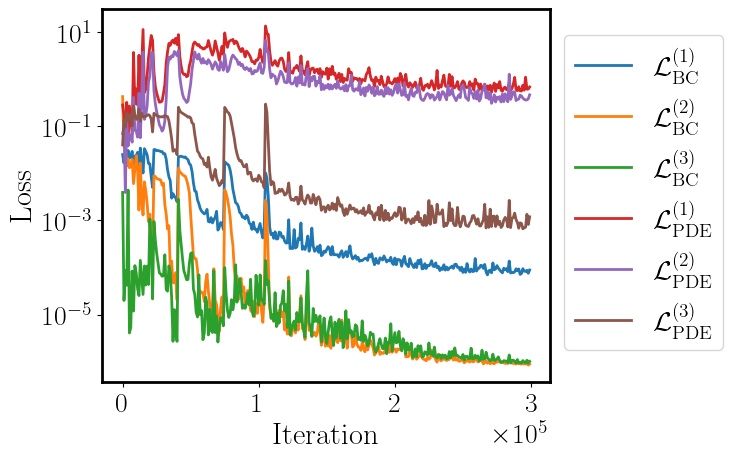

In [13]:
# Losses
losses =  np.load('Stokes_losses.npy'.format(arch, weights))

loss_u_bc1 = losses[0, :]
loss_v_bc1 = losses[1, :]
loss_u_bc2 = losses[2, :]
loss_v_bc2 = losses[3, :]
loss_p_bc3 = losses[4, :]
loss_r_u = losses[5, :]
loss_r_v = losses[6, :]
loss_r_c = losses[7, :]

iters = 1000 * np.arange(len(loss_u_bc1))

fig =plt.figure(figsize = (6,5))
plt.plot(iters, loss_u_bc1 + loss_v_bc1 , lw=2,  label='$\mathcal{L}_{\\text{BC}}^{(1)}$')
plt.plot(iters, loss_u_bc2 + loss_v_bc2 , lw=2,  label='$\mathcal{L}_{\\text{BC}}^{(2)}$')
plt.plot(iters, loss_p_bc3  , lw=2,  label='$\mathcal{L}_{\\text{BC}}^{(3)}$')
plt.plot(iters, loss_r_u, lw=2,  label='$\mathcal{L}_{\\text{PDE}}^{(1)}$')
plt.plot(iters, loss_r_v, lw=2,  label='$\mathcal{L}_{\\text{PDE}}^{(2)}$')
plt.plot(iters, loss_r_c, lw=2,  label='$\mathcal{L}_{\\text{PDE}}^{(3)}$')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
# plt.title('{} + {}'.format(arch.replace('_', ' '), weights.replace('_', ' ')))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='lower left', ncol=1, bbox_to_anchor = (1.0, 0.05))

plt.show()

In [14]:
# index = [5, 91, 144]
idx = 144
sols = np.load('Data/res_{}.npy'.format(idx))
axis = np.load('Data/axis.npy')


a = axis[idx,0]
b = axis[idx,1] 
y_test = sols[:, 0:2]
u_test = sols[:, 2:3]
v_test = sols[:, 3:4]
p_test = sols[:, 4:5]

fn_theta = lambda theta:  np.hstack([a * np.cos(theta) + 0.5, b * np.sin(theta) + 0.5])
theta = np.linspace(0, 2 * np.pi, m)

N = y_test.shape[0]
u =  vmap(fn_theta)(theta).reshape(1, -1)
u = np.tile(u, (N, 1)) 

u_pred, v_pred, p_pred = model.predict_s(params, u, y_test)

error_u = np.linalg.norm(u_pred- sols[:,2]) /  np.linalg.norm(sols[:,2]) 
error_v = np.linalg.norm(v_pred- sols[:,3]) /  np.linalg.norm(sols[:,3]) 
error_p = np.linalg.norm(p_pred- sols[:,4]) /  np.linalg.norm(sols[:,4]) 

print('u relative l2 error: ', error_u)
print('v relative l2 error: ', error_v)
print('p relative l2 error: ', error_p)

# Compute NTK weights for residual
Y_test = np.hstack([y_test, a * np.ones((N,1)), b * np.ones((N,1))])
K_ru = vmap(model.compute_K_ru, (None, 0, 0, 0, 0, 0))(params, u, Y_test[:,0], Y_test[:,1], Y_test[:,2], Y_test[:,3])
K_rv = vmap(model.compute_K_rv, (None, 0, 0, 0, 0, 0))(params, u, Y_test[:,0], Y_test[:,1], Y_test[:,2], Y_test[:,3])
K_rc = vmap(model.compute_K_rc, (None, 0, 0, 0, 0, 0))(params, u, Y_test[:,0], Y_test[:,1], Y_test[:,2], Y_test[:,3])

K_max = np.stack([K_ru, K_rv, K_rc]).max()

lam_ru = K_max / (K_ru)
lam_rv = K_max / (K_rv)
lam_rc = K_max / (K_rc)

ru_index = lam_ru != np.inf
rv_index = lam_rv != np.inf
rc_index = lam_rc != np.inf


lam_ru_removed_nan = lam_ru[ru_index]
lam_rv_removed_nan = lam_rv[rv_index]
lam_rc_removed_nan = lam_rc[rc_index]

# Interpolation for plot
P = 400
y1 = np.linspace(0, 1, P)
y2 = np.linspace(0, 1, P)

Y1, Y2 = np.meshgrid(y1, y2)
Y = np.hstack((Y1.flatten()[:, None], Y2.flatten()[:, None]))  # shape = (P**2, 2)

U_star = griddata((y_test[:,0], y_test[:,1]), u_test.flatten(),(Y1,Y2),method='cubic')
V_star = griddata((y_test[:,0], y_test[:,1]), v_test.flatten(),(Y1,Y2),method='cubic')
P_star = griddata((y_test[:,0], y_test[:,1]), p_test.flatten(),(Y1,Y2),method='cubic')

U_pred = griddata((y_test[:,0], y_test[:,1]), u_pred.flatten(),(Y1,Y2),method='cubic')
V_pred = griddata((y_test[:,0], y_test[:,1]), v_pred.flatten(),(Y1,Y2),method='cubic')
P_pred = griddata((y_test[:,0], y_test[:,1]), p_pred.flatten(),(Y1,Y2),method='cubic')

Lam_ru = griddata((y_test[:,0][ru_index], y_test[:,1][ru_index]), lam_ru_removed_nan, (Y1,Y2),method='linear') 
Lam_rv = griddata((y_test[:,0][rv_index], y_test[:,1][rv_index]), lam_rv_removed_nan, (Y1,Y2),method='linear')
Lam_rc = griddata((y_test[:,0][rc_index], y_test[:,1][rc_index]), lam_rc_removed_nan, (Y1,Y2),method='linear')


mask = ((Y[:,0] - 0.5)**2 / a**2 +  (Y[:,1] - 0.5)**2 / b**2 >= 1)

Y = Y[mask]

U_star = U_star.flatten()[mask]
V_star = V_star.flatten()[mask]
P_star = P_star.flatten()[mask]

U_pred = U_pred.flatten()[mask]
V_pred = V_pred.flatten()[mask]
P_pred = P_pred.flatten()[mask]

Lam_ru = Lam_ru.flatten()[mask]
Lam_rv = Lam_rv.flatten()[mask]
Lam_rc = Lam_rc.flatten()[mask]

u relative l2 error:  0.012600431
v relative l2 error:  0.05066689
p relative l2 error:  0.0226592


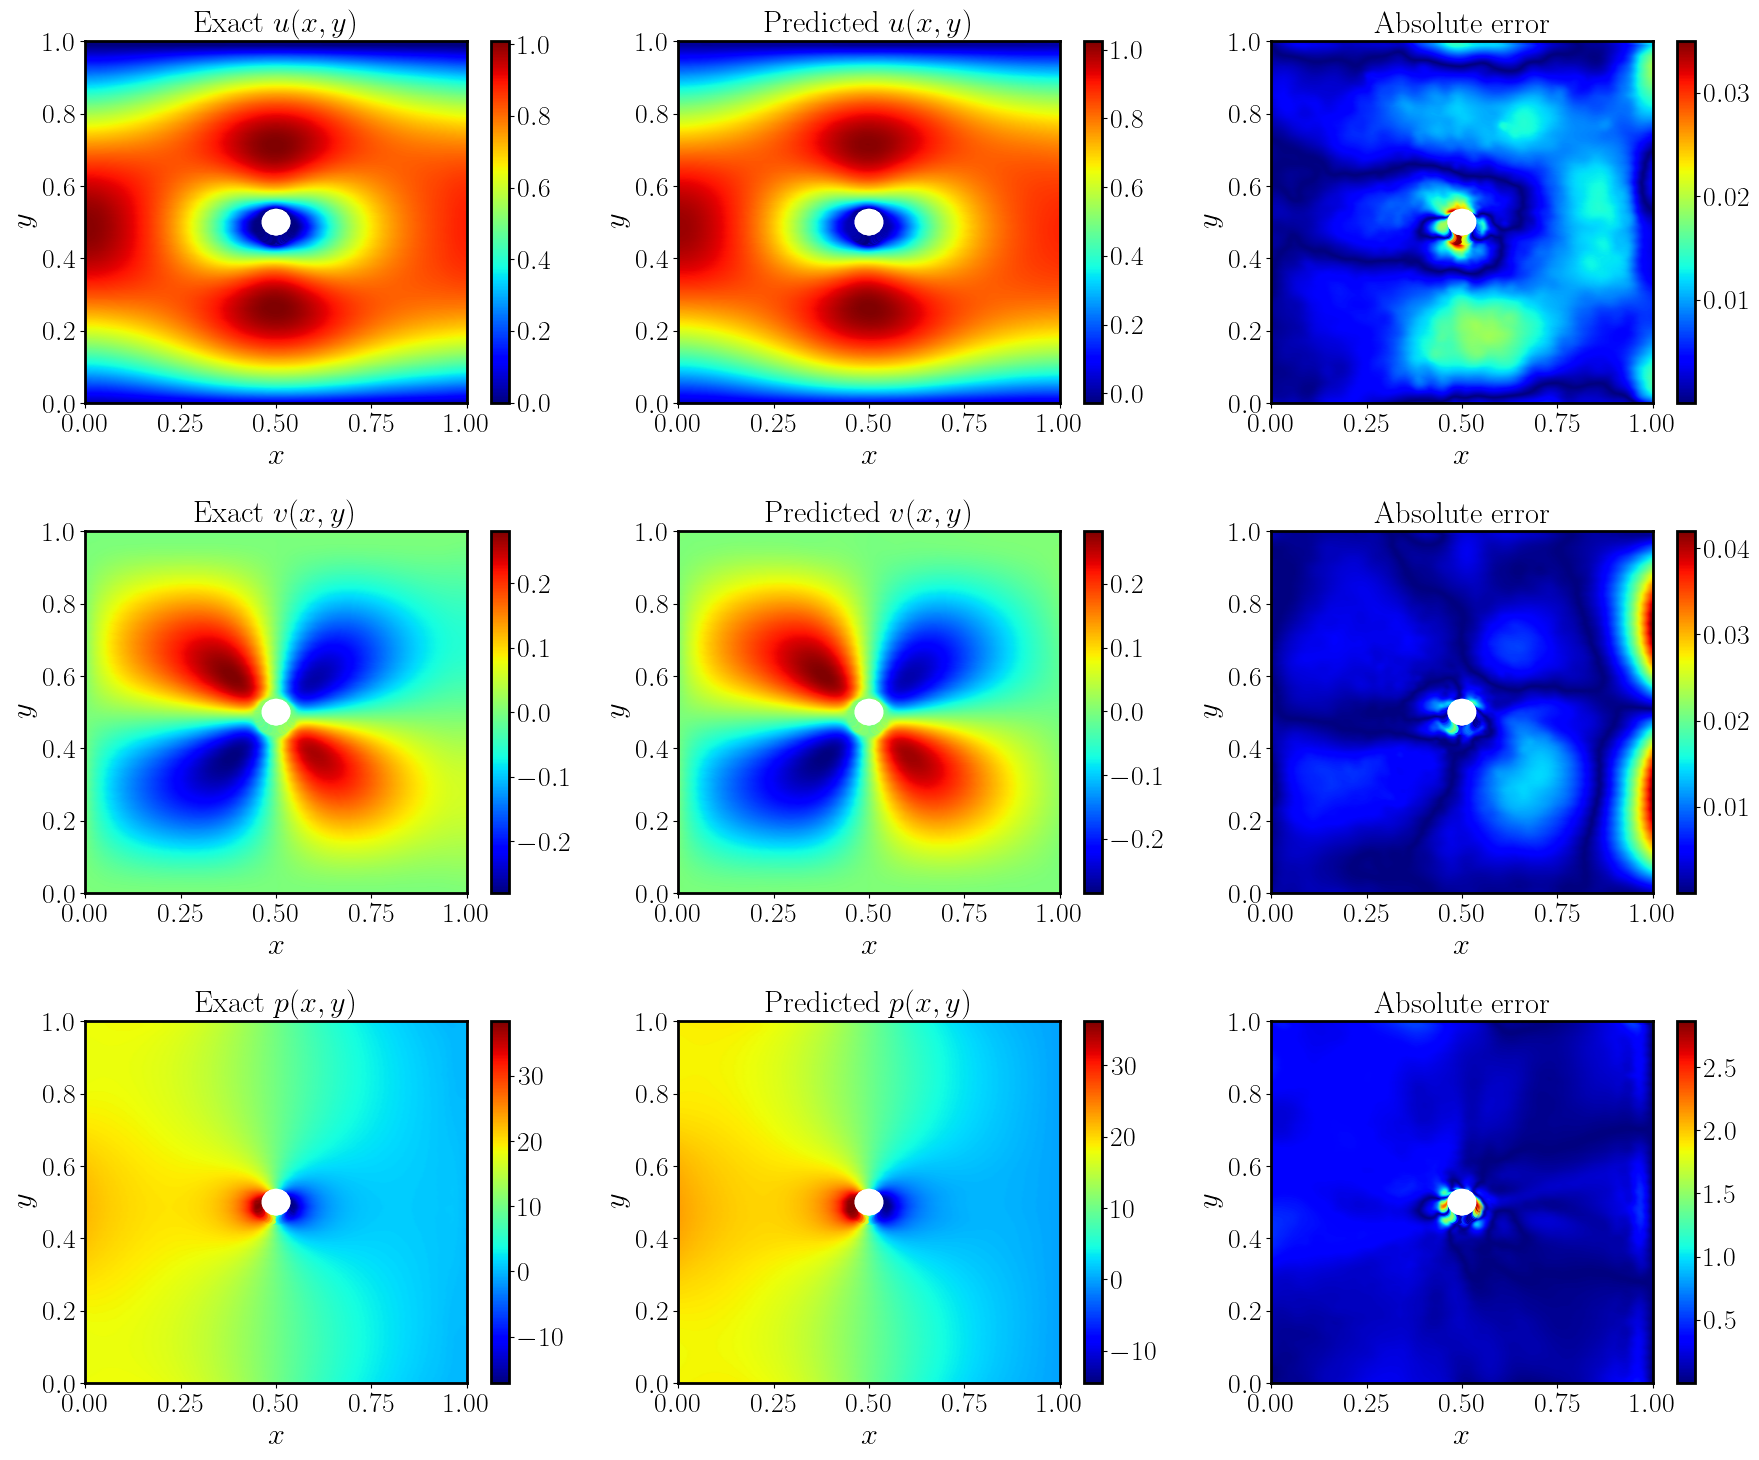

In [15]:
fig = plt.figure(figsize=(18, 15))

plt.subplot(3, 3, 1)
plt.scatter(Y[:,0], Y[:,1], c=U_star, cmap='jet')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Exact $u(x,y)$')
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 3, 2)
plt.scatter(Y[:,0], Y[:,1], c=U_pred, cmap='jet')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Predicted $u(x,y)$')
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 3, 3)
plt.scatter(Y[:,0], Y[:,1], c=np.abs(U_star - U_pred), cmap='jet')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Absolute error')
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 3, 4)
plt.scatter(Y[:,0], Y[:,1], c=V_star, cmap='jet')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Exact $v(x,y)$')
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 3, 5)
plt.scatter(Y[:,0], Y[:,1], c=V_pred, cmap='jet')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Predicted $v(x,y)$')
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 3, 6)
plt.scatter(Y[:,0], Y[:,1], c=np.abs(V_star - V_pred), cmap='jet')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Absolute error')
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 3, 7)
plt.scatter(Y[:,0], Y[:,1], c=P_star, cmap='jet')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Exact $p(x,y)$')
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 3, 8)
plt.scatter(Y[:,0], Y[:,1], c=P_pred, cmap='jet')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Predicted $p(x,y)$')
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 3, 9)
plt.scatter(Y[:,0], Y[:,1], c=np.abs(P_star - P_pred), cmap='jet')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Absolute error')
plt.colorbar()
plt.tight_layout()
plt.show()

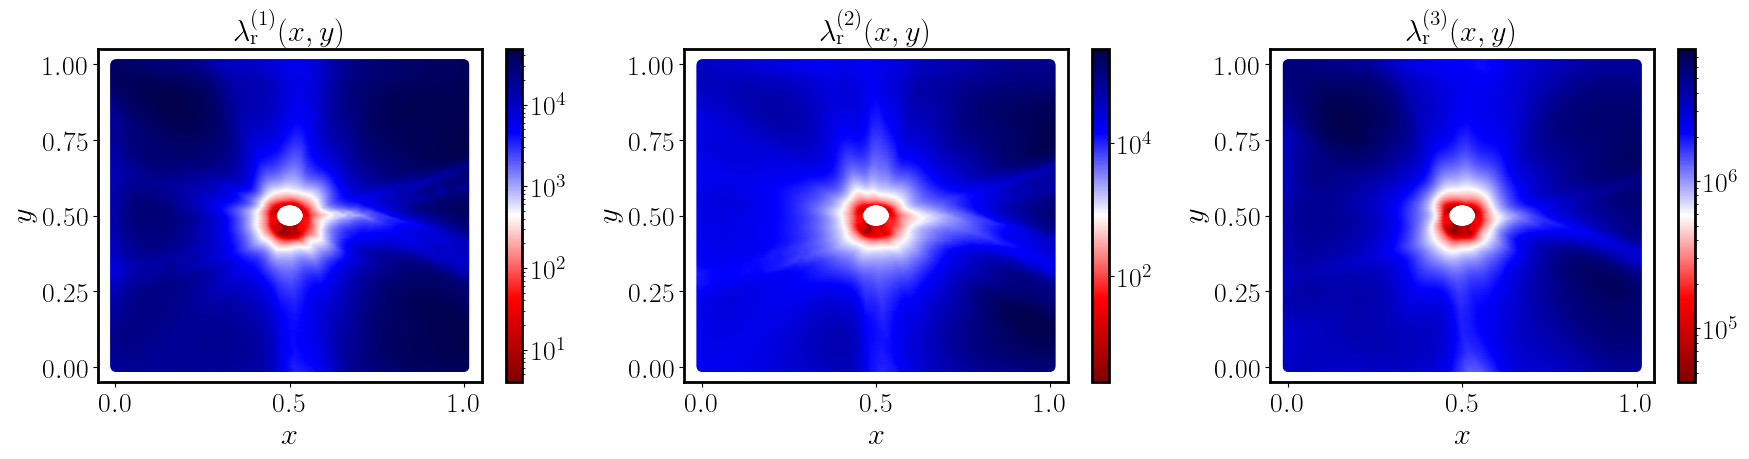

In [16]:
# Visualization of NTK weights
fig = plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.scatter(Y[:,0], Y[:,1], c=Lam_ru, norm=colors.LogNorm(vmin=(Lam_ru).min(), vmax= (Lam_ru).max()), cmap='seismic_r')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$\lambda_{\\text{r}}^{(1)}(x, y)$')
plt.colorbar()
plt.tight_layout()


plt.subplot(1, 3, 2)
plt.scatter(Y[:,0], Y[:,1], c=Lam_rv, norm=colors.LogNorm(vmin=(Lam_rv).min(), vmax= (Lam_rv).max()), cmap='seismic_r')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$\lambda_{\\text{r}}^{(2)}(x, y)$')
plt.colorbar()
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.scatter(Y[:,0], Y[:,1], c=Lam_rc, norm=colors.LogNorm(vmin=(Lam_rc).min(), vmax= (Lam_rc).max()), cmap='seismic_r')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$\lambda_{\\text{r}}^{(3)}(x, y)$')
plt.colorbar()
plt.tight_layout()

plt.show()